In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from scipy.optimize import fsolve, minimize
from finesse.gaussian import HGMode
import scipy
import scipy.integrate as integrate
from scipy.optimize import curve_fit

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from IPython.display import HTML
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from IPython.display import IFrame

import finesse
from finesse.knm.tools import make_scatter_matrix
finesse.configure(plotting=True)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

$$\Delta n\left(E_{y}\right)=\frac{1}{2} n_{e}^{3} r_{33} E_{y}$$
$$\Delta \phi = kL\Delta n\left(E_{y}\right)$$

In [2]:
N = 77
Nz = 11
ne = 2.156
r33 = 31e-12 # Electro-optic coefficients pm/V e-12
epsilon_eff = 1 # Dielectric constant

k = 2*np.pi/(1064e-9)
voltage = 1 # 1 V
phi_factor = 1/2*ne**3*r33*k*voltage
Lx = Ly = 1e-3 #2 mm
Lz = 10e-3 #20 mm
deltaz = 2*Lz/Nz
deltax = 2*Lx/N
phi_factor # w

0.0009173101692806183

In [3]:
with open('./save/fieldpotential.npy', 'rb') as f:
    potential = np.load(f)

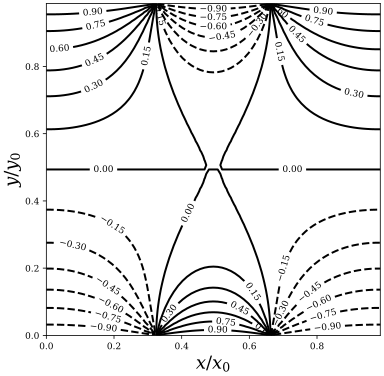

In [4]:
slc = Nz//2
fig, ax = plt.subplots(figsize=(6, 6))

CS = ax.contour(np.arange(N)/N, np.arange(N)/N, potential[:,:,slc].T, levels=15, colors='k', linewidths=2)
ax.clabel(CS, CS.levels, inline=True, fontsize=9)
ax.set_xlabel('$x/x_0$', fontsize=18)
ax.set_ylabel('$y/y_0$', fontsize=18)
plt.grid()
plt.show()

In [5]:
Ex_, Ey_, Ez_ = np.gradient(-potential[:,:,:])
Ey = epsilon_eff*Ey_[:,:, 1:-1]/deltax
Ey.shape

(77, 77, 9)

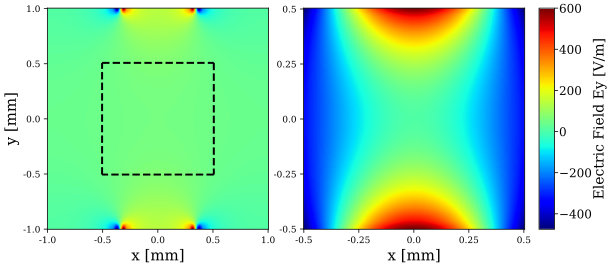

In [142]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

start = 0
end = N - start 
# zslice = 5
zslice = Nz//2

x = np.arange(10*start, 10*end)

Ey_data_slice = scipy.ndimage.zoom(Ey[start:end, start:end, zslice], 10).T

ax1.imshow(Ey_data_slice, cmap="jet")

step = int((end-start)*10/4)
ax1.set_xticks(np.arange(5)*step)
ax1.set_xticklabels(np.linspace(-1, 1, 5)*Lx*1e3)

ax1.set_yticks(np.arange(5)*step)
ax1.set_yticklabels(np.linspace(-1, 1, 5)*Lx*1e3)


start = 19
end = N - start 
Ey_data_slice = scipy.ndimage.zoom(Ey[start:end, start:end, zslice], 10).T

step = int((end-start)*10/4)
ax2.set_xticks(np.arange(5)*step)
ax2.set_xticklabels(np.linspace(-1, 1, 5)*Lx*1e3/2)

ax2.set_yticks(np.arange(5)*step)
ax2.set_yticklabels(np.linspace(-1, 1, 5)*Lx*1e3/2)

img2 = ax2.imshow(Ey_data_slice, cmap="jet")

x = y = np.arange(start*10, (end-0)*10)
lw = 2
ax1.plot([x[0], y[0]], [x[0], y[-1]], color="k", ls="--", lw=lw)
ax1.plot([x[0], y[-1]], [x[-1], y[-1]], color="k", ls="--", lw=lw)
ax1.plot([x[-1], y[0]], [x[0], y[0]], color="k", ls="--", lw=lw)
ax1.plot([x[-1], y[-1]], [x[-1], y[0]], color="k", ls="--", lw=lw)
           
ax1.set_aspect(1)
ax2.set_aspect(1)
ax1.grid(False)
ax2.grid(False)
ax1.set_xlabel('x [mm]', fontsize=15)
ax1.set_ylabel('y [mm]', fontsize=15)
ax2.set_xlabel('x [mm]', fontsize=15)

plt.subplots_adjust(wspace=-0.05) 

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="7%", pad=0.2)
cbar = fig.colorbar(img2, cax=cax,)
cbar.set_label(label=r"Electric Field Ey [V/m]", fontsize=14, rotation=90, labelpad=1)
# cbar.ax.minorticks_on()
cbar.set_ticks([-400, -200, 0, 200, 400, 600])
cbar.ax.tick_params(labelsize=12, rotation=0, pad=1);
# fig.savefig('./Figures/Ey_slice_com.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

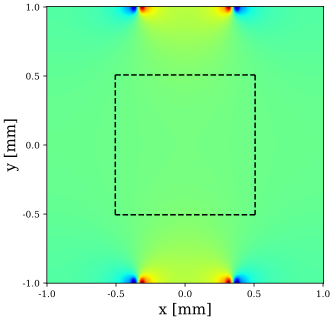

In [12]:
fig, ax = plt.subplots(figsize=(6, 5))

start = 0
end = N - start 
zslice = Nz//2

x = np.arange(10*start, 10*end)

Ey_data_slice = scipy.ndimage.zoom(Ey[start:end, start:end, zslice], 10).T

ax.imshow(Ey_data_slice, cmap="jet")

step = int((end-start)*10/4)
ax.set_xticks(np.arange(5)*step)
ax.set_xticklabels(np.linspace(-1, 1, 5)*Lx*1e3)

ax.set_yticks(np.arange(5)*step)
ax.set_yticklabels(np.linspace(-1, 1, 5)*Lx*1e3)

start = 19
end = N - start 

x = y = np.arange(start*10, (end-0)*10)
lw = 1.5
ax.plot([x[0], y[0]], [x[0], y[-1]], color="k", ls="--", lw=lw)
ax.plot([x[0], y[-1]], [x[-1], y[-1]], color="k", ls="--", lw=lw)
ax.plot([x[-1], y[0]], [x[0], y[0]], color="k", ls="--", lw=lw)
ax.plot([x[-1], y[-1]], [x[-1], y[0]], color="k", ls="--", lw=lw)
           
ax.set_aspect(1)
ax.grid(False)
ax.set_xlabel('x [mm]', fontsize=15)
ax.set_ylabel('y [mm]', fontsize=15);

# fig.savefig('./Figures/Ey_slice.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

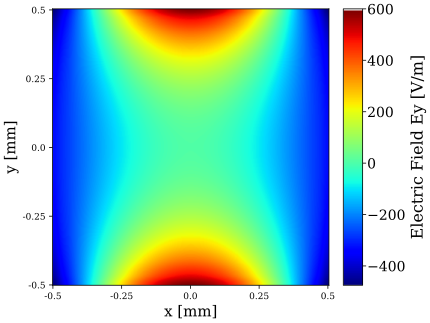

In [14]:
fig, ax = plt.subplots(figsize=(6, 5))

start = 19
end = N - start 
Ey_data_slice = scipy.ndimage.zoom(Ey[start:end, start:end, zslice], 10).T

step = int((end-start)*10/4)
ax.set_xticks(np.arange(5)*step)
ax.set_xticklabels(np.linspace(-1, 1, 5)*Lx*1e3/2)

ax.set_yticks(np.arange(5)*step)
ax.set_yticklabels(np.linspace(-1, 1, 5)*Lx*1e3/2)

img = ax.imshow(Ey_data_slice, cmap="jet")


ax.set_aspect(1)
ax.grid(False)
ax.set_ylabel('y [mm]', fontsize=15)
ax.set_xlabel('x [mm]', fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="7%", pad=0.2)
cbar = fig.colorbar(img, cax=cax,)
cbar.set_label(label=r"Electric Field Ey [V/m]", fontsize=16, rotation=90, labelpad=5)
# cbar.ax.minorticks_on()
cbar.set_ticks([-400, -200, 0, 200, 400, 600])
cbar.ax.tick_params(labelsize=14, rotation=0, pad=1);
# fig.savefig('./Figures/Ey_slice_zoom.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [45]:
Ey_data_slice.min(), Ey_data_slice.max()

(-475.3336037131591, 591.2213674908683)

In [15]:
R = Lx/2 # 1 mm, we zone in to half of the size to get the activate area
# w0 = R*.38
w0 = R*0.1165 # The beam size 
zR = np.pi*w0**2/(1064e-9)
q_0 = zR*1j 
print(q_0)
print(R)

0.010018440059371258j
0.0005


In [16]:
def fsolve_func(w0_, w_sol):
    z = Lz
    zR_ = np.pi*w0_**2/(1064e-9)
    w = w0_*(1+(z/zR_)**2)**0.5
    return w-w_sol

w_lz = 85e-6
w0_s = fsolve(fsolve_func, x0=0.8*w0, args=(w_lz))
w0_l = fsolve(fsolve_func, x0=1.2*w0, args=(w_lz))
print(w0_s/w0, w0_l/w0,)

[0.83322281] [1.19795014]


In [148]:
w0*1e6

58.25000000000001

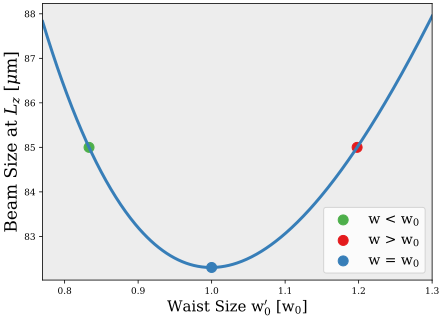

In [18]:
z = Lz
ws = []
range_ = np.linspace(0.77, 1.3, 400)
for w0_ in range_*w0: 
    zR_ = np.pi*w0_**2/(1064e-9)
    w = w0_*(1+(z/zR_)**2)**0.5
    ws.append(w)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
background_color = '#ededed'
ax.patch.set_facecolor(background_color)

ax.plot(range_, np.array(ws)*1e6, lw=3, color=CB_color_cycle[0])

ax.scatter([w0_s/w0], [w_lz*1e6], s=100, color=CB_color_cycle[2], label="w < w$_{0}$")
ax.scatter([w0_l/w0], [w_lz*1e6], s=100, color=CB_color_cycle[7], label="w > w$_{0}$")
ax.scatter([1], [np.sqrt(1+(Lz/zR)**2)*w0*1e6], s=100, color=CB_color_cycle[0], label="w = w$_{0}$")

ax.set_xlabel(r'Waist Size w$_{0}^{\prime}$ [w$_{0}$]', fontsize=15)
ax.set_ylabel(r"Beam Size at $L_{z}$ [$\mu$m]", fontsize=17)
ax.grid();
legend = ax.legend(fontsize=14, ncols=1, loc="best");

In [19]:
np.sqrt(2)*w0*1e6

82.37794000823281

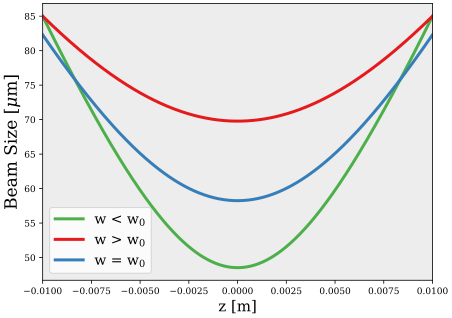

In [20]:
ws_s = []
ws_l = []
ws_0 = []
zs = np.linspace(-Lz, Lz, 400)
for z in zs:
    zR_s = np.pi*w0_s**2/(1064e-9)
    w_s = w0_s*(1+(z/zR_s)**2)**0.5
    ws_s.append(w_s)

    zR_l = np.pi*w0_l**2/(1064e-9)
    w_l = w0_l*(1+(z/zR_l)**2)**0.5
    ws_l.append(w_l)

    zR_0 = np.pi*w0**2/(1064e-9)
    w_0 = w0*(1+(z/zR_0)**2)**0.5
    ws_0.append(w_0)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
background_color = '#ededed'
ax.patch.set_facecolor(background_color)

ax.plot(zs, np.array(ws_s)*1e6, lw=3, color=CB_color_cycle[2], label=r"w < w$_{0}$")
ax.plot(zs, np.array(ws_l)*1e6, lw=3, color=CB_color_cycle[7], label=r"w > w$_{0}$")
ax.plot(zs, np.array(ws_0)*1e6, lw=3, color=CB_color_cycle[0], label=r"w = w$_{0}$")

ax.set_xlabel(r'z [m]', fontsize=15)
ax.set_ylabel(r"Beam Size [$\mu$m]", fontsize=17)
ax.grid();

legend = ax.legend(fontsize=14, ncols=1, loc="best");

In [77]:
zR = np.pi*w0**2/(1064e-9)
q_0 = zR*1j
print(q_0)

Beam_0 = HGMode(q_0, n=0, m=0)
x = y = np.linspace(-R, R, 390)
step = x[1] - x[0]
Beam_0_data = Beam_0.unm(x, y)

0.010018440059371258j
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)


In [65]:
q_0

0.01442655368549461j

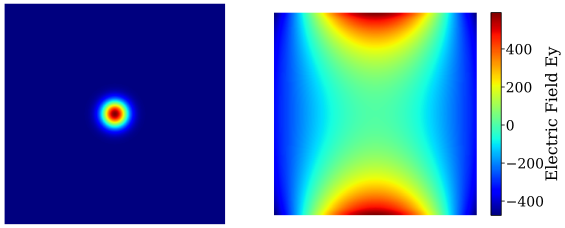

In [78]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4))

img1 = ax1.imshow(np.abs(Beam_0_data), cmap="jet")
img2 = ax2.imshow(Ey_data_slice, cmap="jet")
ax1.set_axis_off()
ax2.set_axis_off()

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes("right", size="5%", pad=0.2)
# cbar = fig.colorbar(img2, cax=cax,)
# cbar.set_label(label=r"$\mathrm{HG_{0,0}}$ Mode", fontsize=16, rotation=90, labelpad=1)
# cbar.ax.minorticks_on()
# cbar.ax.tick_params(labelsize=14, rotation=0, pad=1);

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(img2, cax=cax,)
cbar.set_label(label=r"Electric Field Ey", fontsize=16, rotation=90, labelpad=1)
# cbar.ax.minorticks_on()
cbar.ax.tick_params(labelsize=14, rotation=0, pad=1);

In [90]:
Ey.shape, end-start, Nz, Lz, q_0

((77, 77, 9), 39, 11, 0.01, 0.010018440059371258j)

In [91]:
# phi_data_full = scipy.ndimage.zoom(Ey[start:end, start:end].sum(axis=2), 10).T*deltaz # deltaz for numerical integration 
phi_data_full = scipy.ndimage.zoom(Ey[start:end, start:end, Nz//2], 10).T*2*Lz # deltaz for numerical integration 

phi_data_norm = phi_data_full*phi_factor
HG_00 = HGMode(q_0, n=0, m=0)
HG_00_data = HG_00.unm(x, y)
Beam_data_new = HG_00_data*np.exp(1j*phi_data_norm)
eta_nms = []
indexes = []
for n in range(12):
    temp = []
    temp_index = []
    for m in range(12):
        HG_nm = HGMode(q_0, n=n, m=m)
        HG_nm_data = HG_nm.unm(x, y)
        
        rho_nm = np.sum(np.conj(HG_nm_data)*Beam_data_new)/np.sum(np.conj(HG_nm_data)*HG_nm_data)

        temp.append(rho_nm)
        temp_index.append(f"HG{n}_{m}")
    eta_nms.append(temp)
    indexes.append(temp_index)

eta_nms = np.array(eta_nms)
# eta_nms[0,0] = 0
# eta_nms[0,0] = np.nan

(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(82.75744385449151+0j)
-24.278344418422236
(1.0029764341779306e-32+0j)
(82.75744385449151+0j)
-24.278344418422236
(1.0029764341779306e-32+0j)
(82.75744385449151+0j)
-24.278344418422236
(1.0029764341779306e-32+0j)
(82.75744385449151+0j)
-24.278344418422236
(1.0029764341779

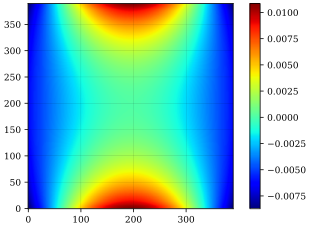

In [92]:
plt.imshow(phi_data_norm, cmap='jet')
plt.colorbar();

In [123]:
len(zdata)

390

In [138]:
def func(x, a, b):
    return a * k*x**2/2 + b

xdata = ydata = np.linspace(-R, R, 390)
# zdata = phi_data_norm[:, 390//2]
zdata = phi_data_norm[390//2,:]
popt, pcov = curve_fit(func, xdata, zdata)
popt

array([-0.00859721, -0.00010409])

In [139]:
popt[0], 1/popt[0], popt[0]*k*w0**2/8*np.sqrt(2)

(-0.008597211179946603, -116.3167891388485, -3.0451781532741616e-05)

In [134]:
4.9936139618713114e-05, -3.0451781532741616e-05

(4.9936139618713114e-05, -3.0451781532741616e-05)

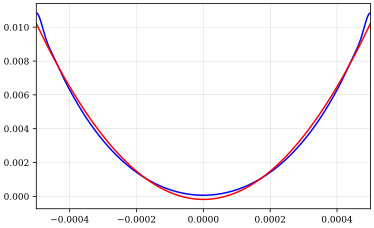

In [136]:
plt.plot(xdata, zdata)
plt.plot(xdata, func(xdata, *popt))

In [137]:
eta_nms = np.array(eta_nms).flatten()
indexes = np.array(indexes).flatten()
np.sort(np.abs(eta_nms).reshape(-1))[-10:]

array([3.82163228e-10, 3.83502970e-10, 1.48068459e-09, 1.48242343e-09,
       1.31638655e-07, 1.32190207e-07, 3.23072298e-07, 3.88056814e-05,
       3.88753708e-05, 9.99999998e-01])

In [149]:
amplitude = 3.88753708e-05/(k*w0**2/8*np.sqrt(2))
1/amplitude

91.11304608948417

In [86]:
# print(f"The HG20 and HG02 are out of phase: \n")
# print(f"HG20 phase: {np.angle(eta_nms[2, 0])*180/np.pi}")
# print(f"HG02 phase: {np.angle(eta_nms[0 ,2])*180/np.pi}")

In [87]:
# # eta_nms[0,0] = 0
# vmax = 3e-04
# fig, ax = plt.subplots(figsize=(8, 7))

# im = ax.imshow(np.abs(eta_nms)[:,::-1].T*100, cmap="jet", vmin=0, vmax=vmax,)

# ax.set_xticks(np.arange(12))
# ax.set_yticks(np.arange(12))
# ax.set_yticklabels(np.arange(12)[::-1])

# color=CB_color_cycle[2]
# ax.text(0, 9, f"2.7e-2", fontsize=9, verticalalignment='center',
#         horizontalalignment='center', color=color, fontweight="bold")

# color=CB_color_cycle[2]
# ax.text(2, 11, f"2.3e-2", fontsize=9, verticalalignment='center',
#         horizontalalignment='center', color=color, fontweight="bold")

# # color=CB_color_cycle[7]
# # ax.text(0, 10, f"0.03", fontsize=9, verticalalignment='center',
# #         horizontalalignment='center', color=color, fontweight="bold")

# plt.grid(False)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.2)
# cbar = fig.colorbar(im, cax=cax, norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
# cbar.set_label(label=r"Power Percentage [%]", fontsize=16, rotation=90, labelpad=10)
# cbar.ax.minorticks_on()
# cbar.ax.set_yticks(np.linspace(0, vmax, 5))
# cbar.ax.tick_params(labelsize=14, rotation=0, pad=5);

# # cbar.ax.ticklabel_format(axis='y',style='sci',scilimits=(1,4))

# ax.set_xlabel("Mode Index n", fontsize=14)
# ax.set_ylabel("Mode Index m", fontsize=16);

In [143]:
eta_nms = np.array(eta_nms).flatten()
indexes = np.array(indexes).flatten()
np.sort(np.abs(eta_nms).reshape(-1))[-10:]

array([3.82163228e-10, 3.83502970e-10, 1.48068459e-09, 1.48242343e-09,
       1.31638655e-07, 1.32190207e-07, 3.23072298e-07, 3.88056814e-05,
       3.88753708e-05, 9.99999998e-01])

In [144]:
# 3.88753708e-05

In [145]:
indices = np.argsort(np.abs(eta_nms))[::-1][:6]
print("Indices:", indices)

Indices: [ 0  2 24 26  4 48]


In [146]:
for index in indices:
    print(indexes[index])
    print(f"{np.abs(eta_nms)[index]*100:.3E}")
    print(f"{np.angle(eta_nms)[index]*180/np.pi:.1f}")

HG0_0
1.000E+02
0.0
HG0_2
3.888E-03
-90.0
HG2_0
3.881E-03
90.0
HG2_2
3.231E-05
-89.7
HG0_4
1.322E-05
90.8
HG4_0
1.316E-05
90.8


In [36]:
num = 10
step = 2/num
point = -1+step/2
points = []
points.append(-1)
points.append(point)
for i in range(num-1):
    points.append(point+step)
    point = point+step
    print(f"{point:.4f}", end=" ")

points.append(1)
print()

for index in range(len(points)-1):
    print(f"{points[index+1] - points[index]:.4f}", end=" ")

-0.7000 -0.5000 -0.3000 -0.1000 0.1000 0.3000 0.5000 0.7000 0.9000 
0.1000 0.2000 0.2000 0.2000 0.2000 0.2000 0.2000 0.2000 0.2000 0.2000 0.1000 

In [81]:
lenz = 200
num = 100
prev_end = 0
for i in range(num):
    start_z = int(i*lenz/num)
    end_z = int((i+1)*lenz/num)
    if start_z!=prev_end:
        print("Gap between the segments")
    prev_end = end_z
    print(f"{start_z}-{end_z}", end="  ")
# end_z

0-2  2-4  4-6  6-8  8-10  10-12  12-14  14-16  16-18  18-20  20-22  22-24  24-26  26-28  28-30  30-32  32-34  34-36  36-38  38-40  40-42  42-44  44-46  46-48  48-50  50-52  52-54  54-56  56-58  58-60  60-62  62-64  64-66  66-68  68-70  70-72  72-74  74-76  76-78  78-80  80-82  82-84  84-86  86-88  88-90  90-92  92-94  94-96  96-98  98-100  100-102  102-104  104-106  106-108  108-110  110-112  112-114  114-116  116-118  118-120  120-122  122-124  124-126  126-128  128-130  130-132  132-134  134-136  136-138  138-140  140-142  142-144  144-146  146-148  148-150  150-152  152-154  154-156  156-158  158-160  160-162  162-164  164-166  166-168  168-170  170-172  172-174  174-176  176-178  178-180  180-182  182-184  184-186  186-188  188-190  190-192  192-194  194-196  196-198  198-200  

In [24]:
# R = 1
# w0 = R*6e-4
# np.pi*w0**2/(1064e-9)

In [25]:
def gouyPhase_Z(z, zR, zlim):
    return 2*(np.arctan(zlim/zR) - np.arctan(z/zR))

In [26]:
start = 30
end = N - start

lenz = 200

R = Lx/2 # 2 mm 
zR_l = np.pi*w0_l**2/(1064e-9)
zR_s = np.pi*w0_s**2/(1064e-9)
zlim = Lz

def HG20_segments(w0, num=1, interpolate=10, voltage=1):
    points = []
    step = 2/num
    point = -1+step/2
    points.append(point)
    for i in range(num-1):
        points.append(point+step)
        point = point+step

    rho_20s = []
    rho_02s = []
    gouy_phases = []
    grids = 41*interpolate
    x = y = np.linspace(-R, R, grids)

    zR = np.pi*w0**2/(1064e-9)

    for i in range(num):
        field_point = points[i]*zlim # the coordinates of the z location, from [-1, 1]
        start_z = int(i*lenz/num)
        end_z = int((i+1)*lenz/num)

        q_0 = np.pi*w0**2/(1064e-9)*1j + field_point # the beam parameter at the z location, from [-1, 1]
        
        HG_20 = HGMode(q_0, n=2, m=0)
        HG_20_data = HG_20.unm(x, y)

        HG_02 = HGMode(q_0, n=0, m=2)
        HG_02_data = HG_02.unm(x, y)

        Beam_0 = HGMode(q_0, n=0, m=0)
        Beam_0_data = Beam_0.unm(x, y)
        
        phi_data = scipy.ndimage.zoom(Ey[start:end, start:end, start_z:end_z].sum(axis=2), interpolate).T*deltaz # The OPD phase for the z slice
        # print(f"The number of data points along the z in this z slice is {end_z-start_z}")
        phi_data_norm = phi_data*phi_factor*voltage
        Beam_0_data_new = Beam_0_data*np.exp(1j*phi_data_norm)

        gouy = gouy_phase_z = gouyPhase_Z(field_point, zR, zlim)
        gouy_phases.append(gouy)
        
        rho_20 = np.sum(np.conj(HG_20_data)*Beam_0_data_new)/np.sum(np.conj(HG_20_data)*HG_20_data)
        rho_20s.append(rho_20*np.exp(1j*gouy))

        rho_02 = np.sum(np.conj(HG_02_data)*Beam_0_data_new)/np.sum(np.conj(HG_02_data)*HG_02_data)
        rho_02s.append(rho_02*np.exp(1j*gouy))

    return np.array(gouy_phases), np.array(rho_20s), np.array(rho_02s)

In [27]:
Gouy_0, HG20_0, HG02_0 = HG20_segments(w0=w0, num=50,)
Gouy_s, HG20_s, HG02_s = HG20_segments(w0=w0_s[0], num=50,)
Gouy_l, HG20_l, HG02_l = HG20_segments(w0=w0_l[0], num=50,)

(-12.49274974287225-32.67887098000429j)
299.2150364727131
(2.873236095519706e-17-3.393212304664186e-17j)
(91.62851923971613-37.36353435187018j)
1.0
(2.873236095519706e-17-3.393212304664186e-17j)
(91.62851923971613-37.36353435187018j)
1.0
(2.873236095519706e-17-3.393212304664186e-17j)
(-10.884014450947426-33.6180176362032j)
311.47245186239263
(5.713263015073177e-18-7.723339442295994e-18j)
(92.93454001153692-36.77273875707459j)
1.0
(5.713263015073177e-18-7.723339442295994e-18j)
(92.93454001153692-36.77273875707459j)
1.0
(5.713263015073177e-18-7.723339442295994e-18j)
(-9.138820055844198-34.4992436220575j)
324.1932335242946
(9.406517975148299e-19-1.7182608556850435e-18j)
(94.26009656615142-36.12147471238145j)
1.0
(9.406517975148299e-19-1.7182608556850435e-18j)
(94.26009656615142-36.12147471238145j)
1.0
(9.406517975148299e-19-1.7182608556850435e-18j)
(-7.252848197942063-35.3068828340373j)
337.36601891116635
(1.0663387614775004e-19-3.6211215411746074e-19j)
(95.60271289152745-35.4056428735703

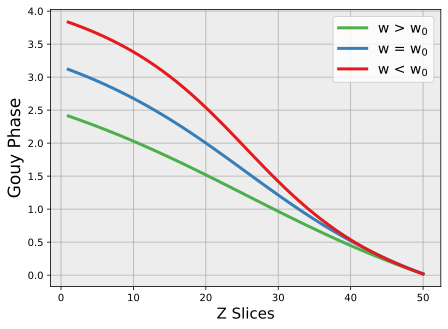

In [28]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
background_color = '#ededed'
ax.patch.set_facecolor(background_color)

ax.plot(range(1, 51), Gouy_l, lw=3, label="w > w$_{0}$", color=CB_color_cycle[2])
ax.plot(range(1, 51), Gouy_0, lw=3, label="w = w$_{0}$", color=CB_color_cycle[0])
ax.plot(range(1, 51), Gouy_s, lw=3, label="w < w$_{0}$", color=CB_color_cycle[7])

ax.set_xlabel(r'Z Slices', fontsize=15)
ax.set_ylabel(r"Gouy Phase", fontsize=17)
ax.grid()
legend = ax.legend(fontsize=14, ncols=1, loc="best");

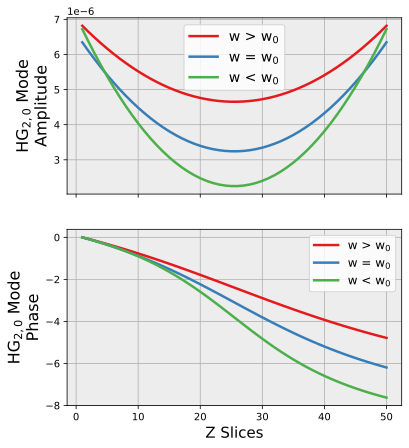

In [29]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(6, 7,), sharex=True)
background_color = '#ededed'

ax.patch.set_facecolor(background_color)
ax1.patch.set_facecolor(background_color)

ax.plot(range(1, 51), np.abs(HG20_l), lw=2.5, color=CB_color_cycle[7], label="w > w$_{0}$")
ax.plot(range(1, 51), np.abs(HG20_0), lw=2.5, color=CB_color_cycle[0], label="w = w$_{0}$")
ax.plot(range(1, 51), np.abs(HG20_s), lw=2.5, color=CB_color_cycle[2], label="w < w$_{0}$")
# ax.plot(range(1, 51), np.abs(HG02_0), lw=2.5, color=CB_color_cycle[7], label=r"$\mathrm{HG_{0,2}}$ Mode Amplitude")


ax1.plot(range(1, 51), np.unwrap(np.angle(HG20_l))-np.angle(HG20_l[0]), lw=2.5, color=CB_color_cycle[7], label="w > w$_{0}$")
ax1.plot(range(1, 51), np.unwrap(np.angle(HG20_0))-np.angle(HG20_0[0]), lw=2.5, color=CB_color_cycle[0], label="w = w$_{0}$")
ax1.plot(range(1, 51), np.unwrap(np.angle(HG20_s))-np.angle(HG20_s[0]), lw=2.5, color=CB_color_cycle[2], label="w < w$_{0}$")
# ax1.plot(range(1, 51), np.unwrap(np.angle(HG02_0)), lw=2.5, color=CB_color_cycle[7], label=r"$\mathrm{HG_{0,2}}$ Mode Phase")

ax1.set_xlabel('Z Slices', fontsize=15)
ax.set_ylabel('$\mathrm{HG_{2, 0}}$ Mode\nAmplitude', fontsize=16)
ax1.set_ylabel('$\mathrm{HG_{2, 0}}$ Mode\nPhase', fontsize=16)

ax.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
# ax1.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
ax.grid()
ax1.grid()
ax.set_xticks(range(0, 51, 10))
ax1.set_xticks(range(0, 51, 10));

legend = ax.legend(fontsize=14, ncols=1, loc="best");
legend = ax1.legend(fontsize=12, ncols=1, loc="best");

In [67]:
results_20_0 = []
results_02_0 = []
results_20_0_abs = []
results_02_0_abs = []

results_20_l = []
results_02_l = []
results_20_l_abs = []
results_02_l_abs = []

results_20_s = []
results_02_s = []
results_20_s_abs = []
results_02_s_abs = []

steps = range(1, 21)
for step in steps:
    _, HG20_0, HG02_0 = HG20_segments(w0=w0, num=step, interpolate=10)
    _, HG20_s, HG02_s = HG20_segments(w0=w0_s[0], num=step, interpolate=10)
    _, HG20_l, HG02_l = HG20_segments(w0=w0_l[0], num=step, interpolate=10)

    results_20_0.append(HG20_0.sum())
    results_02_0.append(HG02_0.sum())
    results_20_0_abs.append(abs(HG20_0).sum())
    results_02_0_abs.append(abs(HG02_0).sum())

    results_20_l.append(HG20_l.sum())
    results_02_l.append(HG02_l.sum())
    results_20_l_abs.append(abs(HG20_l).sum())
    results_02_l_abs.append(abs(HG02_l).sum())

    results_20_s.append(HG20_s.sum())
    results_02_s.append(HG02_s.sum())
    results_20_s_abs.append(abs(HG20_s).sum())
    results_02_s_abs.append(abs(HG02_s).sum())

results_20_0 = np.array(results_20_0)
results_02_0 = np.array(results_02_0)
results_20_0_abs = np.array(results_20_0_abs)
results_02_0_abs = np.array(results_02_0_abs)

results_20_l = np.array(results_20_l)
results_02_l = np.array(results_02_l)
results_20_l_abs = np.array(results_20_l_abs)
results_02_l_abs = np.array(results_02_l_abs)

results_20_s = np.array(results_20_s)
results_02_s = np.array(results_02_s)
results_20_s_abs = np.array(results_20_s_abs)
results_02_s_abs = np.array(results_02_s_abs)

(41.378721927245756+0j)
587.4380076995342
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(45.331124923479+0j)
847.0159178513406
(8.121457550047682e-47+0j)
(128.21578332882606+0j)
1.0
(8.121457550047682e-47+0j)
(128.21578332882606+0j)
1.0
(8.121457550047682e-47+0j)
(37.80573626515034+0j)
408.73399377930974
(5.041521474810098e-23+0j)
(106.93076992335195+0j)
1.0
(5.041521474810098e-23+0j)
(106.93076992335195+0j)
1.0
(5.041521474810098e-23+0j)
(15.728088990484597-35.84170440401763j)
469.8975184793713
(-9.517813844611306e-27-2.2151325944107744e-26j)
(107.75467974769238-25.39554007090398j)
1.0
(-9.517813844611306e-27-2.2151325944107744e-26j)
(107.75467974769238-25.39554007090398j)
1.0
(-9.517813844611306e-27-2.2151325944107744e-26j)
(15.728088990484597+35.84170440401763j)
469.8975184793713
(-9.517813844611306e-27+2.2151325944107744e-26j)
(107.75467974769238+25.39554007090398j)
1.0
(-9.517813844611306

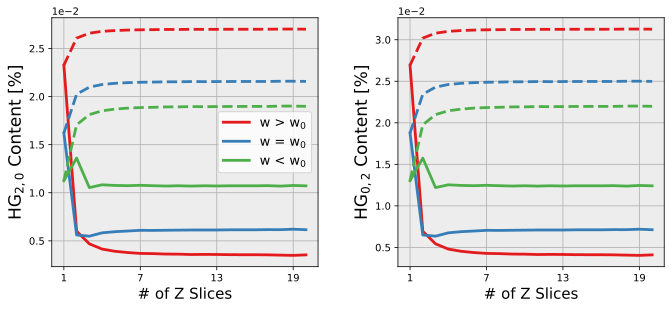

In [76]:
steps = range(1, 21)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(11, 4.5))
background_color = '#ededed'
ax1.patch.set_facecolor(background_color)
ax2.patch.set_facecolor(background_color)

ax1.plot(steps, np.abs(results_20_l)*100, lw=2.8, label="w > w$_{0}$", color=CB_color_cycle[7])
ax1.plot(steps, np.abs(results_20_0)*100, lw=2.8, label="w = w$_{0}$", color=CB_color_cycle[0])
ax1.plot(steps, np.abs(results_20_s)*100, lw=2.8, label="w < w$_{0}$", color=CB_color_cycle[2])

ax1.plot(steps, np.abs(results_20_l_abs)*100, lw=2.8, ls="--", color=CB_color_cycle[7])
ax1.plot(steps, np.abs(results_20_0_abs)*100, lw=2.8, ls="--", color=CB_color_cycle[0])
ax1.plot(steps, np.abs(results_20_s_abs)*100, lw=2.8, ls="--", color=CB_color_cycle[2])

ax2.plot(steps, np.abs(results_02_l)*100, lw=2.8, label="w > w$_{0}$", color=CB_color_cycle[7])
ax2.plot(steps, np.abs(results_02_0)*100, lw=2.8, label="w = w$_{0}$", color=CB_color_cycle[0])
ax2.plot(steps, np.abs(results_02_s)*100, lw=2.8, label="w < w$_{0}$", color=CB_color_cycle[2])

ax2.plot(steps, np.abs(results_02_l_abs)*100, lw=2.8, ls="--", color=CB_color_cycle[7])
ax2.plot(steps, np.abs(results_02_0_abs)*100, lw=2.8, ls="--", color=CB_color_cycle[0])
ax2.plot(steps, np.abs(results_02_s_abs)*100, lw=2.8, ls="--", color=CB_color_cycle[2])

ax1.set_xlabel('# of Z Slices', fontsize=15)
ax1.set_ylabel(r'$\mathrm{HG}_{2,0}$ Content [%]', fontsize=17)
ax2.set_ylabel(r'$\mathrm{HG}_{0,2}$ Content [%]', fontsize=17)
ax2.set_xlabel('# of Z Slices', fontsize=15);

ax1.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
ax2.ticklabel_format(axis='y',style='sci',scilimits=(1,4))

# np.abs(HG20_50).sum(), np.abs(HG20_100).sum()
# ax1.scatter(5, np.abs(HG20_50.sum()))
# ax1.set_xticks(range(1, 50, 10))
ax1.set_xticks(range(1, 21, 6))
ax2.set_xticks(range(1, 21, 6))
plt.subplots_adjust(wspace=0.3);
ax1.grid()
ax2.grid()
legend = ax1.legend(fontsize=13, ncols=1, loc="best");

# ax1.set_xlim([0, 10])

# legend_lines = legend.get_lines()
# for idx, line in enumerate(legend_lines):
#     line.set_linestyle("-")
# legend_lines[-1].set_linestyle((0, (3.8, 2.3)))

### EOBD

In [4]:
def EOBD_func(z, w0):
    c = 1j*np.pi/(1064e-9)*1e-6
    zR = np.pi*w0**2/(1064e-9)
    coeff = c*w0*(1+(z/zR)**2)**0.5*np.exp(-1j*np.arctan(z/zR))

    return coeff

$$
\cos(\arctan(x)) = \frac{1}{\sqrt{1+x^2}}
$$
$$
\cos(2\arctan(x)) = \frac{2}{1+x^2} - 1 = \frac{1 - x^2}{1+x^2}
$$

In [21]:
w0 = 5.825e-05
Lz = 10e-3

m_0, err_0 = integrate.quad(EOBD_func, -Lz, Lz, args=(w0), complex_func=True, points=3)
m_s, err_s = integrate.quad(EOBD_func, -Lz, Lz, args=(w0_s[0]), complex_func=True)
m_l, err_l = integrate.quad(EOBD_func, -Lz, Lz, args=(w0_l[0]), complex_func=True)
m_0, err_0

(3.439807745706869e-06j, (1.8988566594879522e-20+3.8189537595677215e-20j))

In [22]:
m_0/m_s, m_l/m_s

((1.2001591712694746+0j), (1.437730852154869+0j))

In [23]:
w0/w0_s[0], w0_l[0]/w0_s[0]

(1.2001591712694746, 1.437730852154869)

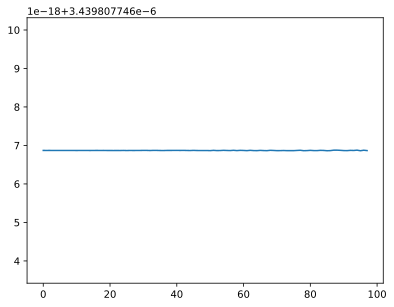

In [24]:
coeffs = []
for n in np.arange(1, 100):
    deltaz = 2*Lz/n
    points = np.linspace(-Lz, Lz, n)
    coeff = 0
    for point in points:
        coeff += EOBD_func(point, w0)*deltaz
    coeffs.append(coeff)

coeffs = np.array(coeffs)
plt.plot(np.abs(coeffs)[1:]);

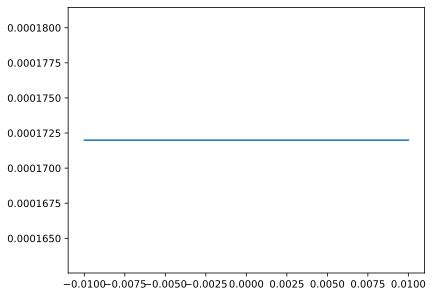

In [25]:
z_vals = np.linspace(-Lz, Lz, 100)
plt.plot(z_vals, EOBD_func(z_vals, w0).imag, );

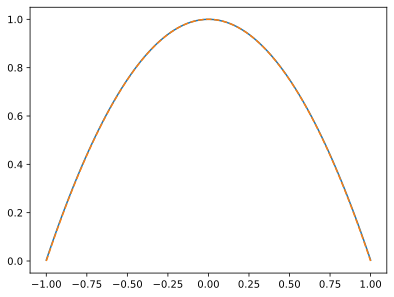

In [30]:
z_vals = np.linspace(-Lz, Lz, 100)
plt.plot(z_vals/Lz, EOL_func(z_vals, w0).imag/w0**2, );
plt.plot(z_vals/Lz, 1-(z_vals/Lz)**2, ls='--');

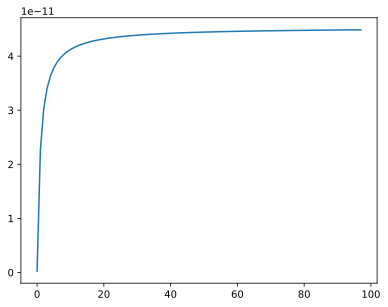

In [29]:
coeffs = []
for n in np.arange(1, 100):
    deltaz = 2*Lz/n
    points = np.linspace(-Lz, Lz, n)
    coeff = 0
    for point in points:
        coeff += EOL_func(point, w0)*deltaz
    coeffs.append(coeff)

coeffs = np.array(coeffs)
plt.plot(np.abs(coeffs)[1:]);

In [28]:
def EOL_func(z, w0):
    c = 1j*np.pi/(1064e-9)*1e-6
    zR = np.pi*w0**2/(1064e-9)
    # coeff = c*w0**2*(1+(z/zR)**2)*np.exp(-2j*np.arctan(z/zR))
    coeff = 1j*w0**2*(1+(z/zR)**2)*np.exp(-2j*np.arctan(z/zR))

    return coeff

In [168]:
m_0, err_0 = integrate.quad(EOL_func, -Lz, Lz, args=(w0), complex_func=True, points=None)
m_s, err_s = integrate.quad(EOL_func, -Lz, Lz, args=(w0_s[0]), complex_func=True)
m_l, err_l = integrate.quad(EOL_func, -Lz, Lz, args=(w0_l[0]), complex_func=True)
m_0, err_0

((4.532402751210378e-11+0j), (5.031977891268166e-25+7.4922086354681845e-25j))

In [169]:
m_0/m_s, m_l/m_s

((3.0935456802063572+0j), (5.575134284207823+0j))

In [190]:
def EOL_sol(w0):
    zR = np.pi*w0**2/(1064e-9)

    return w0**2*(2*Lz - 2/(3*zR**2)*Lz**3)

In [192]:
EOL_sol(w0)/EOL_sol(w0_s[0]), EOL_sol(w0_l[0])/EOL_sol(w0_s[0]), 

(3.093545680206358, 5.575134284207826)

In [31]:
k = 2*np.pi/(1064e-9)
Lx = Ly = 1e-3 #2 mm
Lz = 10e-3 #20 mm

R = Lx/2 # 1 mm, we zone in to half of the size to get the activate area
# w0 = R*.38
w0 = R*0.1165 # The beam size 
zR = np.pi*w0**2/(1064e-9)
q_0 = zR*1j 
print(q_0)

def fsolve_func(w0_, w_sol):
    z = Lz
    zR_ = np.pi*w0_**2/(1064e-9)
    w = w0_*(1+(z/zR_)**2)**0.5
    return w-w_sol

# w_lz = 90e-6
w_lz = 85e-6
w0_s = fsolve(fsolve_func, x0=0.8*w0, args=(w_lz))
w0_l = fsolve(fsolve_func, x0=1.2*w0, args=(w_lz))
print(w0_s/w0, w0_l/w0,)

0.010018440059371258j
[0.83322281] [1.19795014]


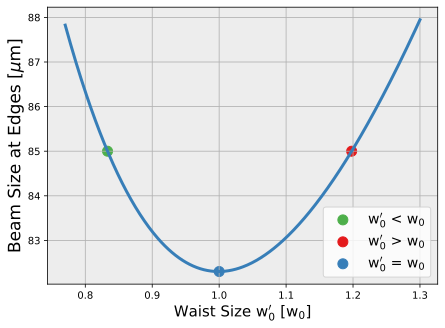

In [34]:
z = Lz
ws = []
# range_ = np.linspace(0.7, 1.425, 400)
range_ = np.linspace(0.77, 1.3, 400)
for w0_ in range_*w0: 
    zR_ = np.pi*w0_**2/(1064e-9)
    w = w0_*(1+(z/zR_)**2)**0.5
    ws.append(w)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
background_color = '#ededed'
ax.patch.set_facecolor(background_color)

ax.plot(range_, np.array(ws)*1e6, lw=3, color=CB_color_cycle[0])

ax.scatter([w0_s/w0], [w_lz*1e6], s=100, color=CB_color_cycle[2], label="w$_{0}^{\prime}$ < w$_{0}$")
ax.scatter([w0_l/w0], [w_lz*1e6], s=100, color=CB_color_cycle[7], label="w$_{0}^{\prime}$ > w$_{0}$")
ax.scatter([1], [np.sqrt(1+(Lz/zR)**2)*w0*1e6], s=100, color=CB_color_cycle[0], label="w$_{0}^{\prime}$ = w$_{0}$")

ax.set_xlabel(r'Waist Size w$_{0}^{\prime}$ [w$_{0}$]', fontsize=15)
# ax.set_ylabel(r"Beam Size at $L_{z}$ [$\mu$m]", fontsize=17)
ax.set_ylabel(r"Beam Size at Edges [$\mu$m]", fontsize=17)

ax.grid();
legend = ax.legend(fontsize=14, ncols=1, loc="best");
# fig.savefig('./Beamsize_Lz.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

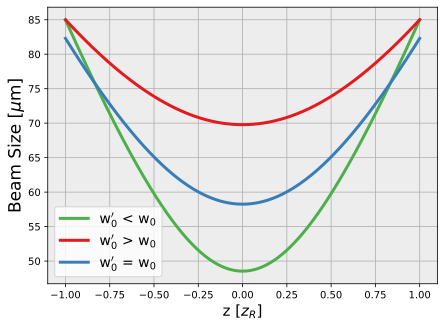

In [42]:
ws_s = []
ws_l = []
ws_0 = []
zs = np.linspace(-1, 1, 400)
for z in zs*Lz:
    zR_s = np.pi*w0_s**2/(1064e-9)
    w_s = w0_s*(1+(z/zR_s)**2)**0.5
    ws_s.append(w_s)

    zR_l = np.pi*w0_l**2/(1064e-9)
    w_l = w0_l*(1+(z/zR_l)**2)**0.5
    ws_l.append(w_l)

    zR_0 = np.pi*w0**2/(1064e-9)
    w_0 = w0*(1+(z/zR_0)**2)**0.5
    ws_0.append(w_0)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
background_color = '#ededed'
ax.patch.set_facecolor(background_color)

ax.plot(zs, np.array(ws_s)*1e6, lw=3, color=CB_color_cycle[2], label="w$_{0}^{\prime}$ < w$_{0}$")
ax.plot(zs, np.array(ws_l)*1e6, lw=3, color=CB_color_cycle[7], label="w$_{0}^{\prime}$ > w$_{0}$")
ax.plot(zs, np.array(ws_0)*1e6, lw=3, color=CB_color_cycle[0], label="w$_{0}^{\prime}$ = w$_{0}$")

ax.set_xlabel(r'z [$z_{R}$]', fontsize=15)
ax.set_ylabel(r"Beam Size [$\mu$m]", fontsize=17)
ax.grid();

legend = ax.legend(fontsize=14, ncols=1, loc="best");

# fig.savefig('./Beamprofile_ws.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [37]:
def gouyPhase_Z_HG10(z, zR, zend):
    return np.arctan(zend/zR) - np.arctan(z/zR)

ne = 1.7710
r33 = 35e-12 # Electro-optic coefficients pm/V e-12
epsilon_eff = 13 # Dielectric constant

k = 2*np.pi/(1064e-9)
voltage = 1 # 1 V
phi_factor = 1/2*ne**3*r33*k*voltage
Lx = Ly = 1e-3 #2 mm
Lz = 10e-3 #20 mm
deltaz = 2*Lz/Nz
deltax = 2*Lx/N
phi_factor # w

lenz = 200
zlim = Lz
print(zlim)
shape = 400
k = 2*np.pi/(1064e-9)

0.01


In [38]:
def HG10_segments(w0, num=1, amplitude=1e-6, zend=Lz, extra_gouy=True):
    points = [] # the center of each z slice from [-1, 1]
    step = 2/num
    point = -1+step/2
    points.append(point)
    for i in range(num-1):
        points.append(point+step)
        point = point+step

    rho_10s = []
    gouy_phases = []
    x = y = np.linspace(-R, R, shape)
    xx, yy = np.meshgrid(x, y)

    # zstart = zend - 2*Lz # the front of the crystal, defaults to -Lz
    zR = np.pi*w0**2/(1064e-9)

    for i in range(num):
        field_point = zend - Lz + points[i]*Lz # the coordinates of the z location, defaults to [-Lz, Lz]

        q_0 = zR*1j + field_point # the beam parameter at the z location, from [-Lz, Lz]

        HG_10 = HGMode(q_0, n=1, m=0)
        HG_10_data = HG_10.unm(x, y)

        Beam_0 = HGMode(q_0, n=0, m=0)
        Beam_0_data = Beam_0.unm(x, y)

        phi_data = k*yy/num*amplitude 
        # a linear map from EOBD, devided by num so the total phase shifts along the crystal for different number of z slices is fixed

        Beam_0_data_new = Beam_0_data*np.exp(1j*phi_data)

        if extra_gouy:
            gouy = gouyPhase_Z_HG10(field_point, zR, zend) # For the 1st order modes
        else:
            gouy = 0
        gouy_phases.append(gouy)

        rho_10 = np.sum(np.conj(HG_10_data)*Beam_0_data_new)/np.sum(np.conj(HG_10_data)*HG_10_data)
        rho_10s.append(rho_10*np.exp(1j*gouy))

    return np.array(gouy_phases), np.array(rho_10s)
    # return np.array(rho_10s)

In [39]:
Gouy_10_0, HG10_0 = HG10_segments(w0=w0, num=51, extra_gouy=False)
Gouy_10_s, HG10_s = HG10_segments(w0=w0_s[0], num=51, extra_gouy=False)
Gouy_10_l, HG10_l = HG10_segments(w0=w0_l[0], num=51, extra_gouy=False)

(27.819700148749465-64.19514007527835j)
-17.352152072253222
(2.916985687351546e-17-3.442632049248605e-17j)
(91.61581886179529-37.36904046914497j)
1.0
(2.916985687351546e-17-3.442632049248605e-17j)
(30.062415140510982-63.93634998833791j)
-17.694781326954946
(6.0049925798792986e-18-8.068701635531671e-18j)
(92.89583785462312-36.79095836086487j)
1.0
(6.0049925798792986e-18-8.068701635531671e-18j)
(32.39475860694024-63.56482963349278j)
-18.043253898912344
(1.0339008146573927e-18-1.851377740938861e-18j)
(94.19469854880585-36.15487060374267j)
1.0
(1.0339008146573927e-18-1.851377740938861e-18j)
(34.81493125366299-63.068259168607526j)
-18.396953450015776
(1.2665170532213163e-19-4.0400576010787456e-19j)
(95.51008580191224-35.45691774002952j)
1.0
(1.2665170532213163e-19-4.0400576010787456e-19j)
(37.319859371526064-62.433588114201406j)
-18.75513119208943
(1.2117557032229708e-21-8.022254879692249e-20j)
(96.83921600999832-34.69316790403189j)
1.0
(1.2117557032229708e-21-8.022254879692249e-20j)
(39.90

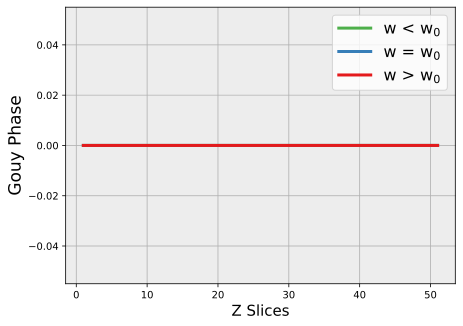

In [40]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
background_color = '#ededed'
ax.patch.set_facecolor(background_color)

ax.plot(range(1, 52), Gouy_10_s, lw=3, label="w < w$_{0}$", color=CB_color_cycle[2])
ax.plot(range(1, 52), Gouy_10_0, lw=3, label="w = w$_{0}$", color=CB_color_cycle[0])
ax.plot(range(1, 52), Gouy_10_l, lw=3, label="w > w$_{0}$", color=CB_color_cycle[7])

ax.set_xlabel(r'Z Slices', fontsize=15)
ax.set_ylabel(r"Gouy Phase", fontsize=17)
ax.grid();
legend = ax.legend(fontsize=16, ncols=1, loc="best");

In [41]:
def phase_norm(phase):
    shape = phase.shape[0]
    length = shape//2
    # print(length)
    return phase-phase[length]

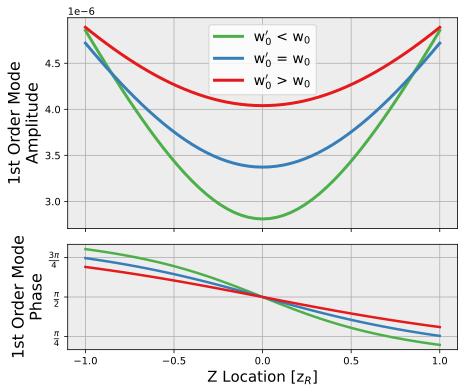

In [42]:
z_vals = np.linspace(-1, 1, 51)
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(7, 6,), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
background_color = '#ededed'

ax.patch.set_facecolor(background_color)
ax1.patch.set_facecolor(background_color)

plt.subplots_adjust(hspace=0.1) 

ax.plot(z_vals, np.abs(HG10_s), lw=3, color=CB_color_cycle[2], label="w$_{0}^{\prime}$ < w$_{0}$")
ax.plot(z_vals, np.abs(HG10_0), lw=3, color=CB_color_cycle[0], label="w$_{0}^{\prime}$ = w$_{0}$")
ax.plot(z_vals, np.abs(HG10_l), lw=3, color=CB_color_cycle[7], label="w$_{0}^{\prime}$ > w$_{0}$")

ax1.plot(z_vals, np.unwrap(np.angle(HG10_s)), lw=2.5, color=CB_color_cycle[2], label="w$_{0}^{\prime}$ < w$_{0}$")
ax1.plot(z_vals, np.unwrap(np.angle(HG10_0)), lw=2.5, color=CB_color_cycle[0], label="w$_{0}^{\prime}$ = w$_{0}$")
ax1.plot(z_vals, np.unwrap(np.angle(HG10_l)), lw=2.5, color=CB_color_cycle[7], label="w$_{0}^{\prime}$ > w$_{0}$")

ax1.set_xlabel('Z Location [z$_{R}$]', fontsize=15)
ax.set_ylabel('1st Order Mode\nAmplitude', fontsize=16)
ax1.set_ylabel('1st Order Mode\nPhase', fontsize=16)

ax.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
# ax1.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
ax.grid()
ax1.grid()
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
# ax1.set_xticks(range(0, 52, 10))

ax1.set_yticks([np.pi/4, 2*np.pi/4, 3*np.pi/4, ])
ax1.set_yticklabels([r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$"])

ax1.tick_params(axis='y', labelsize=12)  # Adjust the fontsize as needed for x-axis

legend = ax.legend(fontsize=14, ncols=1, loc="best");
# legend = ax1.legend(fontsize=14, ncols=1, loc="best");

# fig.savefig('./HG10amp_phase.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [43]:
results_10_0 = []
results_10_0_abs = []
results_10_s = []
results_10_s_abs = []
results_10_l = []
results_10_l_abs = []

steps = range(1, 21)
for step in steps:
    _, HG10_0_ = HG10_segments(w0=w0, num=step, extra_gouy=False)
    _, HG10_s_ = HG10_segments(w0=w0_s[0], num=step, extra_gouy=False)
    _, HG10_l_ = HG10_segments(w0=w0_l[0], num=step, extra_gouy=False)

    results_10_0.append(HG10_0_.sum())
    results_10_0_abs.append(np.abs(HG10_0_).sum())

    results_10_l.append(HG10_l_.sum())
    results_10_l_abs.append(np.abs(HG10_l_).sum())

    results_10_s.append(HG10_s_.sum())
    results_10_s_abs.append(np.abs(HG10_s_).sum())

results_10_0 = np.array(results_10_0)
results_10_0_abs = np.array(results_10_0_abs)
results_10_l = np.array(results_10_l)
results_10_l_abs = np.array(results_10_l_abs)
results_10_s = np.array(results_10_s)
results_10_s_abs = np.array(results_10_s_abs)

(82.75744385449151+0j)
-24.278344418422236
(1.0029764341779306e-32+0j)
(117.03669948635185+0j)
1.0
(1.0029764341779306e-32+0j)
(90.662249846958+0j)
-29.137877717008504
(8.121457550047682e-47+0j)
(128.21578332882606+0j)
1.0
(8.121457550047682e-47+0j)
(75.61147253030067+0j)
-20.266573311226292
(5.041521474810098e-23+0j)
(106.93076992335195+0j)
1.0
(5.041521474810098e-23+0j)
(60.15617846971108-50.092279080019765j)
-21.723202307196132
(-9.51781384461115e-27-2.215132594410781e-26j)
(107.75467974769238-25.395540070903987j)
1.0
(-9.51781384461115e-27-2.215132594410781e-26j)
(60.15617846971108+50.092279080019765j)
-21.723202307196132
(-9.51781384461115e-27+2.215132594410781e-26j)
(107.75467974769238+25.395540070903987j)
1.0
(-9.51781384461115e-27+2.215132594410781e-26j)
(48.517845799733436-65.72769913648203j)
-23.659110304214543
(4.0976247308403355e-31+1.3505479675126589e-32j)
(109.96952624018711-35.42494725689828j)
1.0
(4.0976247308403355e-31+1.3505479675126589e-32j)
(48.517845799733436+65.72

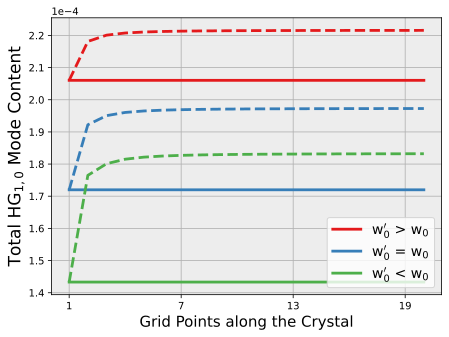

In [44]:
steps = range(1, 21)

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))
background_color = '#ededed'
ax1.patch.set_facecolor(background_color)

ax1.plot(steps, np.abs(results_10_l), lw=2.8, color=CB_color_cycle[7], label="w$_{0}^{\prime}$ > w$_{0}$")
ax1.plot(steps, np.abs(results_10_0), lw=2.8, color=CB_color_cycle[0], label="w$_{0}^{\prime}$ = w$_{0}$")
ax1.plot(steps, np.abs(results_10_s), lw=2.8, color=CB_color_cycle[2], label="w$_{0}^{\prime}$ < w$_{0}$")

ax1.plot(steps, np.abs(results_10_l_abs), lw=2.8, color=CB_color_cycle[7], ls="--",)
ax1.plot(steps, np.abs(results_10_0_abs), lw=2.8, color=CB_color_cycle[0], ls="--",)
ax1.plot(steps, np.abs(results_10_s_abs), lw=2.8, color=CB_color_cycle[2], ls="--",)

ax1.set_xlabel('Grid Points along the Crystal', fontsize=15)
ax1.set_ylabel(r'Total $\mathrm{HG}_{1,0}$ Mode Content', fontsize=17)
# ax2.set_ylabel(r'$\mathrm{HG}_{1,0}$ AMP SUM', fontsize=17)

ax1.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
# ax2.ticklabel_format(axis='y',style='sci',scilimits=(1,4))

ax1.set_xticks(range(1, 21, 6))

ax1.grid()
legend = ax1.legend(fontsize=14, ncols=1, loc="best");
# fig.savefig('./EOBD_Convergence.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [46]:
np.abs(results_10_0).mean()/np.abs(results_10_s).mean(), np.abs(results_10_l).mean()/np.abs(results_10_s).mean(),

(1.2001591709031365, 1.4377308510327012)

In [ ]:
# (1.2001591712694746, 1.437730852154869)

In [72]:
step_0 = 20
results_10 = []
results_10_abs = []

results_10_0 = []
results_10_abs_0 = []

w0_evals = 1 + np.linspace(-0.2, 0.2, 100)
for w0_ in w0_evals*w0:
    _, HG10_ = HG10_segments(w0=w0_, num=step_0, extra_gouy=True)
    _, HG10_0 = HG10_segments(w0=w0_, num=step_0, extra_gouy=False)

    results_10.append(np.abs(HG10_.sum()))
    results_10_abs.append(np.abs(HG10_).sum())

    results_10_0.append(np.abs(HG10_0.sum()))
    results_10_abs_0.append(np.abs(HG10_0).sum())

results_10 = np.array(results_10)
results_10_abs = np.array(results_10_abs)

results_10_0 = np.array(results_10_0)
results_10_abs_0 = np.array(results_10_abs_0)

(7.263507890767389-68.82242628560628j)
-16.977572951988254
(-2.250897363129846e-16+5.3709887015267444e-18j)
(86.42082691564933-45.93485048031923j)
1.0
(-2.250897363129846e-16+5.3709887015267444e-18j)
(13.137220412392256-70.58985693709273j)
-18.27582292513773
(2.669330520560496e-19-6.8774126931672085e-19j)
(90.88573097030586-45.28590101918235j)
1.0
(2.669330520560496e-19-6.8774126931672085e-19j)
(20.29699304942834-71.77088791969524j)
-19.72042179385297
(7.352327217406583e-22+2.3837553673066237e-22j)
(95.80159573991968-44.137408317038805j)
1.0
(7.352327217406583e-22+2.3837553673066237e-22j)
(28.936745449468418-71.93545795066518j)
-21.312145856979868
(1.1735858222669625e-25+1.8614169919990932e-25j)
(101.16356029618468-42.308684259365826j)
1.0
(1.1735858222669625e-25+1.8614169919990932e-25j)
(39.1612912725996-70.45775488329261j)
-23.034462694157522
(1.4794007547843338e-29+5.283462692543367e-30j)
(106.91067130967694-39.57160945396685j)
1.0
(1.4794007547843338e-29+5.283462692543367e-30j)
(50

In [73]:
z = Lz
ws_s = []
for w0_ in w0_evals*w0:
    zR_ = np.pi*w0_**2/(1064e-9)
    w_s = w0_*(1+(z/zR_)**2)**0.5
    ws_s.append(w_s*1e6)

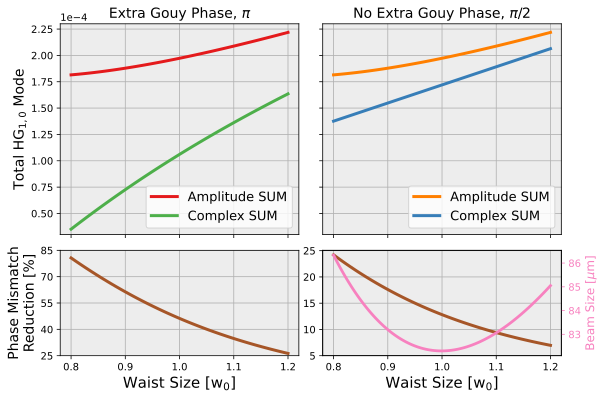

In [74]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(9, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
background_color = '#ededed'
ax1.patch.set_facecolor(background_color)
ax2.patch.set_facecolor(background_color)
ax3.patch.set_facecolor(background_color)
ax4.patch.set_facecolor(background_color)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
plt.subplots_adjust(wspace=0.1, hspace=0.1) 

ax1.plot(w0_evals, results_10_abs, label="Amplitude SUM", lw=3, color=CB_color_cycle[7],)
ax1.plot(w0_evals, results_10, label="Complex SUM", lw=3, color=CB_color_cycle[2],)

ax2.plot(w0_evals, results_10_abs_0, label="Amplitude SUM", ls='-', lw=3, color=CB_color_cycle[1],)
ax2.plot(w0_evals, results_10_0, label="Complex SUM", ls='-', lw=3, color=CB_color_cycle[0],)

ax3.plot(w0_evals, (1-results_10/results_10_abs)*100, lw=3, color=CB_color_cycle[4],)
ax4.plot(w0_evals, (1-results_10_0/results_10_abs_0)*100, lw=3, color=CB_color_cycle[4],)

ax4_y = ax4.twinx()

ax4_y.plot(w0_evals, ws_s, color=CB_color_cycle[3], lw=2.8,)
ax4_y.set_ylabel('Beam Size [$\mu$m]', color=CB_color_cycle[3], fontsize=12)
ax4_y.tick_params('y', colors=CB_color_cycle[3])

ax1.set_ylabel(r'Total HG$_{1,0}$ Mode', fontsize=14)
ax3.set_xlabel('Waist Size [w$_{0}$]', fontsize=15)
ax3.set_ylabel('Phase Mismatch\nReduction [%]', fontsize=14)

xlabel = ax4.set_xlabel('Waist Size [w$_{0}$]', fontsize=15)
# xlabel.set_position((1, 0))

ax1.set_ylim([0.3e-4, 2.3e-4])
ax2.set_ylim([0.3e-4, 2.3e-4])
ax3.set_ylim([25, 85])
ax3.set_yticks([25, 40, 55, 70, 85])
ax4.set_yticks([5, 10, 15, 20, 25])
ax2.set_yticklabels([])

ax1.ticklabel_format(axis='y', style='sci', scilimits=(1,4))

ax1.set_title("Extra Gouy Phase, $\pi$", fontsize=14)
ax2.set_title("No Extra Gouy Phase, $\pi/2$", fontsize=14)
legend = ax1.legend(fontsize=13, ncols=1, loc="best")
legend = ax2.legend(fontsize=13, ncols=1, loc="lower right");

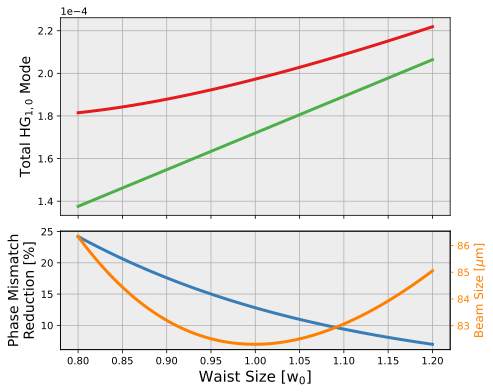

In [89]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(7, 6,), sharex=True, gridspec_kw={'height_ratios': [5, 3]})
background_color = '#ededed'

ax.patch.set_facecolor(background_color)
ax1.patch.set_facecolor(background_color)

ax.plot(w0_evals, results_10_abs_0, label="Amplitude SUM", ls='-', lw=3, color=CB_color_cycle[7],)
ax.plot(w0_evals, results_10_0, label="Complex SUM", ls='-', lw=3, color=CB_color_cycle[2],)

ax1.plot(w0_evals, (1-results_10_0/results_10_abs_0)*100, lw=3, color=CB_color_cycle[0],)

ax1_y = ax1.twinx()

ax1_y.plot(w0_evals, ws_s, color=CB_color_cycle[1], lw=3,)
ax1_y.set_ylabel('Beam Size [$\mu$m]', color=CB_color_cycle[1], fontsize=12)
ax1_y.tick_params('y', colors=CB_color_cycle[1])

ax.grid()
ax1.grid()
plt.subplots_adjust(hspace=0.1)

ax.ticklabel_format(axis='y', style='sci', scilimits=(1,4))

ax1_y.set_ylabel('Beam Size [$\mu$m]', color=CB_color_cycle[1], fontsize=12)
ax1_y.tick_params('y', colors=CB_color_cycle[1])

ax.set_ylabel(r'Total HG$_{1,0}$ Mode', fontsize=14)
ax1.set_xlabel('Waist Size [w$_{0}$]', fontsize=15)
ax1.set_ylabel('Phase Mismatch\nReduction [%]', fontsize=14);
# fig.savefig('./EOBD_waist_size_design.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [29]:
zs = np.linspace(-1, 1, 51)
zR_0 = np.pi*w0**2/(1064e-9)
print(zR_0)
ws_arr = []
for z in zs:
    z = z*zR_0
    w_0 = w0*(1+(z/zR_0)**2)**0.5
    ws_arr.append(w_0*1e6)
ws_arr = np.array(ws_arr)

0.010018440059371258


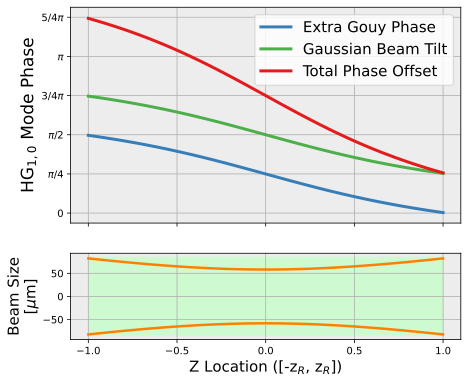

In [234]:
xrange = np.linspace(-1, 1, 51)
fig, (ax, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(7, 6), gridspec_kw={'height_ratios': [2.5, 1]}, sharex=True)
background_color = '#ededed'
ax.patch.set_facecolor(background_color)
ax2.patch.set_facecolor(background_color)

ax.plot(xrange, Gouy_10_0, lw=3, label="Extra Gouy Phase", color=CB_color_cycle[0])
ax.plot(xrange, np.unwrap(np.angle(HG10_0)) - Gouy_10_0 + 2*np.pi, lw=3, color=CB_color_cycle[2], label="Gaussian Beam Tilt")
ax.plot(xrange, np.unwrap(np.angle(HG10_0)) + 2*np.pi, lw=3, color=CB_color_cycle[7], label="Total Phase Offset")

ax2.plot(xrange, ws_arr, color=CB_color_cycle[1], lw=2.5)
ax2.plot(xrange, -ws_arr, color=CB_color_cycle[1], lw=2.5)

ax2.add_patch(Rectangle((-1, -85), 2, 170, color="#cefad0"),)

ax2.set_xlabel(r'Z Location ([-z$_{R}$, z$_{R}$])', fontsize=15)
ax.set_ylabel(r"$\mathrm{HG_{1,0}}$ Mode Phase", fontsize=17)
ax2.set_ylabel("Beam Size\n[$\mu$m]", fontsize=15)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])

ax.set_yticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2])
ax.set_yticklabels([0, "$\pi/4$", "$\pi/2$", "$3/4\pi$", "$\pi$", "$5/4\pi$", "$3/2\pi$"])

ax.set_ylim([-0.2, 5/4*np.pi+0.2])

ax.grid()
ax2.grid()
legend = ax.legend(fontsize=15, ncols=1, loc="best");

In [31]:
def wrap(phase):
    phase = (phase) % (2 * np.pi)
    phase = phase/np.pi

    return phase

wrap(-np.pi), wrap(-2*np.pi), wrap(-3*np.pi)

(1.0, 0.0, 1.0)

In [32]:
w0_ = 1e-3
zR0_ = np.pi*w0_**2/(1064e-9)

def scatter_matrix_10(z):
    z = z*zR0_
    # Non-astigmatic beam with perfect mode matching from input to output
    qx1 = qy1 = qx2 = qy2 = finesse.BeamParam(w0=w0_, z=z)
    
    # angular misalignment along x
    xgamma = -1e-6
    ygamma = 0
    
    # Compute the scattering matrix, returning a KnmMatrix object
    kmat = make_scatter_matrix(
        "bayerhelms",
        qx1, qx2, qy1, qy2,
        xgamma, ygamma,
        maxtem=2,
    )
    return kmat["00->10"]

In [33]:
scatter_matrix_10s = []
z_s = np.linspace(-1, 1, 100)
for z in z_s:
    HG10 = scatter_matrix_10(z)
    scatter_matrix_10s.append(HG10)

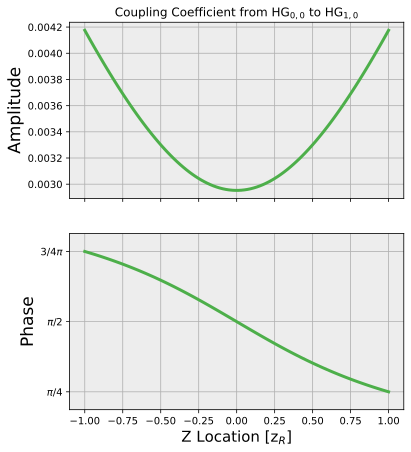

In [34]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(6, 7,), sharex=True)
background_color = '#ededed'

ax.patch.set_facecolor(background_color)
ax1.patch.set_facecolor(background_color)

ax.plot(z_s, np.abs(scatter_matrix_10s), lw=3, color=CB_color_cycle[2])
ax1.plot(z_s, np.angle(scatter_matrix_10s), lw=3, color=CB_color_cycle[2])
ax1.set_xlabel(r'Z Location [z$_{R}$]', fontsize=15)
ax.set_title("Coupling Coefficient from HG$_{0,0}$ to HG$_{1,0}$")
ax.set_ylabel("Amplitude", fontsize=17)
ax1.set_ylabel("Phase", fontsize=17)
ax.grid()
ax1.grid()

ax1.set_yticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax1.set_yticklabels([0, "$\pi/4$", "$\pi/2$", "$3/4\pi$", "$\pi$"])
ax1.set_ylim([np.pi/4-0.2, 3*np.pi/4+0.2]);
# legend = ax.legend(fontsize=16, ncols=1, loc="best");

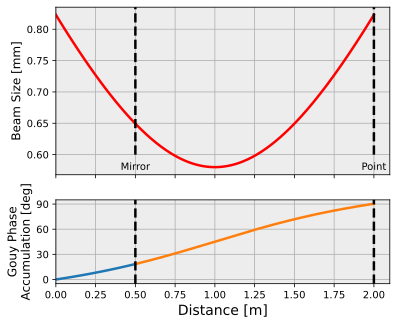

In [197]:
kat = finesse.Model()
kat.modes(maxtem=3)

Ltot = 2
L1 = 0.5
L2 = Ltot - L1
w0 = 5.8e-4
kat.parse(
    f"""
    l L0 P=1

#    tem(L0, 0, 0, 0, phase=0.0)
#    tem(L0, 1, 0, 1, phase=0.0)
    
    gauss input L0.p1.o priority=1 w0={w0} z=-1

    s s0 L0.p1 mirror.p1 L={L1}

    bs mirror R=1 T=0

    s s1 mirror.p2 point.p1 L={L2}
    
    nothing point

    # amplitude detectors
    ad HG10 point.p2.o f=0 n=1 m=0
    ad HG00 point.p2.o f=0 n=0 m=0
    
    ad HG10_mirror mirror.p2.o f=0 n=1 m=0
    ad HG00_mirror mirror.p2.o f=0 n=0 m=0

#    bp gouyd mirror.p2.o gouy 
    
    noxaxis()
    """
)

tsy = finesse.tracing.tools.propagate_beam(
    from_node=kat.L0.p1.o, to_node=kat.point.p2.o, direction="x"
)

fig, (ax1, ax2)  = tsy.plot()
background_color = '#ededed'

ax1.patch.set_facecolor(background_color)
ax2.patch.set_facecolor(background_color)
ax1.grid()
ax2.grid()
ax2.set_ylim([-5, 95])
ax2.set_yticks([0, 30, 60, 90])

ax2.set_xlabel('Distance [m]', fontsize=14)
ax1.set_ylabel('Beam Size [mm]', fontsize=12)
ax2.set_ylabel('Gouy Phase\nAccumulation [deg]', fontsize=12)

for line in ax1.get_lines()+ax2.get_lines():
    line.set_linewidth(2.5)

fig.set_size_inches(6, 5);

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
ax1.set_subplotspec(gs[0])
ax2.set_subplotspec(gs[1])

text_objects = ax1.texts
for text_object in text_objects:
    # text_properties = text_object.properties()
    # print(text_properties)
    text_object.set_text(text_object.get_text().capitalize())

In [198]:
kat1 = kat.deepcopy()
kat1.mirror.xbeta = 1e-6

L1 = 1.3
L2 = 2 - L1
kat1.s0.L = L1
kat1.s1.L = L2

out1 = kat1.run()

print(r"The phase of the HG10 mode relative to the HG00 mode [pi]:")
print()
# print(f'Gouy phase at the MIRROR {out1["gouyd"]:.3f}')
print("#"*15)
print(f'HG10 mode at the END: {out1["HG10"]}')
print(f'HG00 mode at the END: {out1["HG00"]}')
print(f'Phase Difference at the END: {np.angle(out1["HG10"]) - np.angle(out1["HG00"]):.3f} radians.', end=" "*3)
print()
print()
print(f'HG10 mode at the MIRROR: {out1["HG10_mirror"]}')
print(f'HG00 mode at the MIRROR: {np.angle(out1["HG00_mirror"])}')
print(f'Phase Difference at the MIRROR: {np.angle(out1["HG10_mirror"]) - np.angle(out1["HG00_mirror"]):.3f} radians.', end=" "*3)

The phase of the HG10 mode relative to the HG00 mode [pi]:

###############
HG10 mode at the END: (-0.00170101999711393+0.0031476105771762086j)
HG00 mode at the END: (0.9999935994778621+0j)
Phase Difference at the END: 2.066 radians.   

HG10 mode at the MIRROR: (-2.1684043449710093e-19+0.0035778375279116596j)
HG00 mode at the MIRROR: 0.0
Phase Difference at the MIRROR: 1.571 radians.   

In [203]:
def HG10phase(L): # L in between [-1, 1]
    kat1 = kat.deepcopy()
    kat1.s0.L = Ltot/2 + L
    kat1.s1.L = Ltot/2 - L
    kat1.mirror.xbeta = 1e-6
    out1 = kat1.run()
    phase = np.angle(out1["HG10"]) - np.angle(out1["HG00"])
    # phase = np.angle(out1["HG10_mirror"]) - np.angle(out1["HG00_mirror"])
    
    return phase

In [204]:
L_vals = np.linspace(-1, 1, 100)
zR_0 = np.pi*w0**2/(1064e-9)
L_vals_plot = L_vals/zR_0
phases = []
for L in L_vals:
    phase = HG10phase(L)
    phases.append(phase)

phases = np.array(phases)

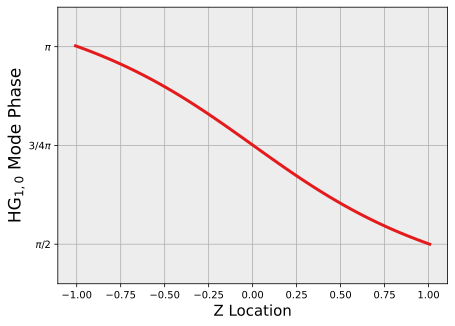

In [207]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))
background_color = '#ededed'
ax1.patch.set_facecolor(background_color)

ax1.plot(L_vals_plot, wrap(np.unwrap(phases)), lw=3, color=CB_color_cycle[7],)

ax1.set_xlabel('Z Location', fontsize=15)
ax1.set_ylabel(r'$\mathrm{HG}_{1,0}$ Mode Phase', fontsize=17)
ax1.grid()

ax1.set_yticks([1/2, 3/4, 1,])
ax1.set_yticklabels(["$\pi/2$", "$3/4\pi$", "$\pi$",]);
ax1.set_ylim([1/2-0.1, 1+0.1]);
# legend = ax.legend(fontsize=16, ncols=1, loc="best");

In [1]:
# Only terms that are mode dependant only depends on the transverse coordinates
# simply sum over the HG10 coefficients, no need for extra Gouy phase, as it is part of the HG10 mode basis

$$
\mathcal{U}_{n}^{\text {tilt }}(x, z) = \mathcal{U}_{n}(x, z) \cdot e^{ik\alpha x}=\mathcal{U}_{n}(x, z)+i \frac{\alpha}{\Theta}\left(\sqrt{n+1} \mathcal{U}_{n+1}(x, z) e^{-i \Psi}+\sqrt{n} \mathcal{U}_{n-1}(x, z) e^{i \Psi}\right),
$$
$$
\text{The special case } \mathrm{HG_{0,0}} \text{ mode:}\,\,\, \mathcal{U}_{0}^{\text {tilt }}(x, z) = \mathcal{U}_{0}(x, z) \cdot e^{ik\alpha x}=\mathcal{U}_{0}(x, z)+i \frac{\alpha}{\Theta} e^{-i \Psi}\cdot \mathcal{U}_{1}(x, z), \,\,\, \mathrm{HG_{1,0}} \text{ mode coefficient = } i \frac{\alpha}{\Theta} e^{-i \Psi}
$$

$$
\text{HG Mode Basis:} \,\,\, \mathcal{U}_{0}(x, z) \sim e^{i \Psi(z)} \text{,}\,\, \mathcal{U}_{1}(x, z) \sim e^{i 2\Psi(z)} 
$$

In [38]:
IFrame(src='./illustration_EOBD.pdf', width=880, height=330)

### Check if `HGMode` considers the Gouy phase

In [237]:
w0 = 5.825e-05
zR0 = np.pi*w0**2/(1064e-9)
phases_HG10 = []
phases_HG00 = []
x0 = w0
y0 = w0
z_eval = np.linspace(-1, 1, 100)
for z in z_eval:
    q_ = zR0*1j + z*zR0
    HG_10 = HGMode(q_, n=1, m=0)
    HG_00 = HGMode(q_, n=0, m=0)
    HG_10_data = HG_10.unm(x0, y0)
    HG_00_data = HG_00.unm(x0, y0)
    HG_00_0 = HG_00.unm(0, 0)
    phase = np.angle(HG_10_data) - np.angle(HG_00_data)
    phases_HG10.append(phase[0][0])
    phases_HG00.append(np.angle(HG_00_0)[0][0])

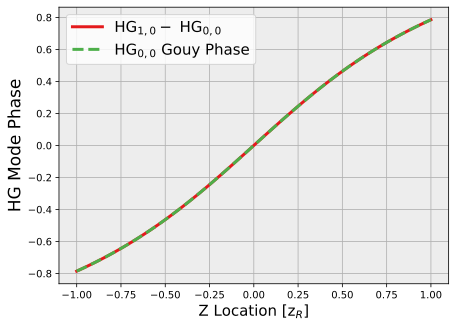

In [246]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))
background_color = '#ededed'
ax1.patch.set_facecolor(background_color)

ax1.plot(z_eval, np.unwrap(phases_HG10), label="HG$_{1,0}-$ HG$_{0,0}$", lw=3, color=CB_color_cycle[7],)
ax1.plot(z_eval, np.unwrap(phases_HG00), label="HG$_{0,0}$ Gouy Phase", ls='--', lw=3, color=CB_color_cycle[2],)

ax1.set_xlabel('Z Location [z$_{R}$]', fontsize=15)
ax1.set_ylabel(r'HG Mode Phase', fontsize=17)
ax1.grid()
legend = ax1.legend(fontsize=15, ncols=1, loc="best");